In [1]:
using SoapySDR


ENV["SOAPY_SDR_PLUGIN_PATH"]="/Users/valiha/miniforge3/envs/gnuradio-env/lib/SoapySDR/modules0.8/"

# Get the Devices
devs = Devices()

# we can add arguments to the device constructor or filter multiple devices:
# devs[1]["refclk"] = "26000000"
# devs = filter(x -> haskey(x, "driver") && x["driver"] == "plutosdr", devs)

# Now open the first device and get the first RX and TX channel streams
dev = Device(devs[1])
c_tx = dev.tx[1]
c_rx = dev.rx[1]

# Configure channel with appropriate parameters.  We choose to sneak into
# the very high end of the 2.4 GHz ISM band, above Wifi channel 14 (which
# itself is well outside of the typical US equipment range, which only goes
# up to channel 11, e.g. 2.473 GHz).
c_tx.bandwidth = 2u"MHz"
c_rx.bandwidth = 200u"kHz"
c_tx.frequency = 2.498u"GHz"
c_rx.frequency = 2.498u"GHz"
c_tx.gain = 52u"dB"
c_rx.gain = -2u"dB"
c_tx.sample_rate = 1u"MHz"
c_rx.sample_rate = 1u"MHz"


[INFO] bladerf_open_with_devinfo()
[INFO] bladerf_get_serial() = b1f3da6672d54d37a2cd7c4d3e3c2e25
[INFO] setSampleRate(Rx, 0, 4.000000 MHz), actual = 4.000000 MHz
[INFO] setSampleRate(Tx, 0, 4.000000 MHz), actual = 4.000000 MHz
[INFO] setSampleRate(Tx, 0, 1.000000 MHz), actual = 1.000000 MHz
[INFO] setSampleRate(Rx, 0, 1.000000 MHz), actual = 1.000000 MHz


1 MHz

In [2]:
# Write out a sinusoid oscillating at 100KHz, lasting 10ms
t = (1:round(Int, 0.01 * 1e6)) ./ 1e6
data_tx = ComplexF32.(sin.(2π .* t .* 100e3), 0.0f0)
data_tx_zeros = zeros(ComplexF32, length(data_tx))

# Open both RX and TX streams
s_tx = SoapySDR.Stream(ComplexF32, [c_tx])
s_rx = SoapySDR.Stream(ComplexF32, [c_rx])


Stream on bladerf2

In [3]:
# Then, do the actual writing and reading!
function loopback_test(s_tx, s_rx, num_buffers)
    # allocate some recieve buffers
    data_rx_buffs = Vector{ComplexF32}[]
    for _ = 1:num_buffers
        push!(data_rx_buffs, Vector(undef, length(data_tx)))
    end

    SoapySDR.activate!.((s_tx, s_rx))
    # Read/write `num_buffers`, writing zeros out except for one buffer.
    for idx = 1:num_buffers
        if idx == ceil(num_buffers / 2)
            Base.write(s_tx, [data_tx])
        else
            Base.write(s_tx, [data_tx_zeros])
        end
        Base.read!(s_rx, [data_rx_buffs[idx]])
    end
    SoapySDR.deactivate!.((s_tx, s_rx))
    return data_rx_buffs
end


loopback_test (generic function with 1 method)

In [4]:
# This should take about 100ms, since we're rx/tx'ing 10x buffers which should each be 10ms long.
loopback_test(s_tx, s_rx, 2)
data_rx_buffs = loopback_test(s_tx, s_rx, 3)

# Join all buffers together
data_rx = vcat(data_rx_buffs...);


00[WARNING @ host/libraries/libbladeRF/src/backend/usb/libusb.c:1169] Transfer callback occurred out of order. (Warning only this time.)


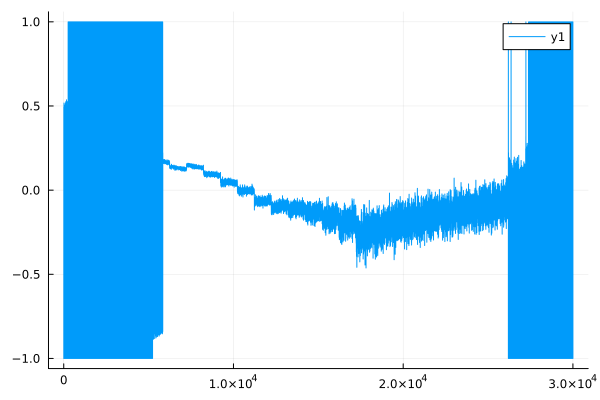

In [5]:
# Should see a nice big spike of a sinusoid being transmitted in the middle
using Plots;
# plotly(size = (750, 750));
plot(real.(data_rx))